### Load Trained RoBERTa Model

In [ ]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification

# Path to the saved model folder
model_path = "./roberta-multilabel-full"

# Load tokenizer and model from the saved directory
tokenizer = RobertaTokenizer.from_pretrained(model_path)
model = RobertaForSequenceClassification.from_pretrained(model_path)

# Move model to device
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Loaded model and tokenizer from:", model_path)

Loaded model and tokenizer from: ./roberta-multilabel-full


### Set up Trainer for evaluation/inference

In [3]:
from transformers import Trainer

trainer = Trainer(model=model)
print("Trainer is ready for predictions or evaluation.")

Trainer is ready for predictions or evaluation.


### Precision, Recall, F1-Score Table

In [ ]:
import pandas as pd
from torch.utils.data import Dataset
from transformers import RobertaTokenizer

# Load CSV
df = pd.read_csv("batch.400K(no_dupe).csv")

# Extract labels
all_possible_labels = ['neutral', 'positive', 'mixed', 'sarcastic', 'negative', 'ironic']

# Convert the multi-label list into binary columns
for label in all_possible_labels:
    df[label] = df['label_list'].apply(lambda x: int(label in x.strip("[]").replace("'", "").split(", ")))

test_df = df.copy()

# Custom dataset class
class MultiLabelDataset(Dataset):
    def __init__(self, dataframe, tokenizer):
        self.texts = dataframe["tweet"].tolist()
        self.labels = dataframe[all_possible_labels].values.tolist()
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = torch.tensor(self.labels[idx], dtype=torch.float)
        encoding = self.tokenizer(text, truncation=True, padding="max_length", max_length=128, return_tensors="pt")
        encoding = {k: v.squeeze() for k, v in encoding.items()}
        encoding["labels"] = labels
        return encoding

# Tokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# Dataset
test_dataset = MultiLabelDataset(test_df, tokenizer)

In [ ]:
from sklearn.metrics import classification_report
import numpy as np
import torch

# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Make sure trainer also uses the correct device (important)
trainer.model.to(device)

# Evaluate the model on test set
predictions = trainer.predict(test_dataset)

# Convert logits to probabilities and apply threshold
probs = torch.sigmoid(torch.tensor(predictions.predictions))
y_pred = (probs >= 0.5).int().numpy()
y_true = predictions.label_ids.astype(int)

# Generate classification report
report = classification_report(
    y_true, y_pred,
    target_names=all_possible_labels,
    zero_division=0
)
print("Classification Report (Multi-Label):")
print(report)

  0%|          | 0/43123 [00:00<?, ?it/s]

📋 Classification Report (Multi-Label):
              precision    recall  f1-score   support

     neutral       0.80      0.52      0.63     43823
    positive       0.91      0.89      0.90     94529
       mixed       0.70      0.48      0.57     45435
   sarcastic       0.86      0.53      0.66     61810
    negative       0.87      0.85      0.86    110051
      ironic       0.73      0.58      0.65     50494

   micro avg       0.84      0.70      0.76    406142
   macro avg       0.81      0.64      0.71    406142
weighted avg       0.83      0.70      0.75    406142
 samples avg       0.79      0.74      0.75    406142



### Test Reviews (Without Custom Thresholds)

In [ ]:
import torch

# Label names
label_names = ['neutral', 'positive', 'mixed', 'sarcastic', 'negative', 'ironic']

# Test review examples with expected labels
test_reviews = [
    # Positive
    ("Absolutely amazing product! It exceeded my expectations!", ["positive"]),
    ("Fantastic service, will definitely use again!", ["positive"]),
    ("This is hands down the best thing I’ve bought!", ["positive"]),
    ("I love it! Works perfectly every time.", ["positive"]),
    ("Exceeded expectations, truly outstanding!", ["positive"]),

    # Negative
    ("Horrible experience, I regret buying this.", ["negative"]),
    ("The worst purchase I’ve ever made. Never again!", ["negative"]),
    ("Disappointed. The quality is awful and not worth the price.", ["negative"]),
    ("Terrible. Nothing works as promised.", ["negative"]),
    ("Awful experience. I want my money back.", ["negative"]),

    # Neutral
    ("It’s okay, not great but not bad either.", ["neutral"]),
    ("I guess it does what it says, nothing special.", ["neutral"]),
    ("Nothing extraordinary, just a standard product.", ["neutral"]),
    ("Average performance, can't complain.", ["neutral"]),
    ("Mediocre. Doesn’t stand out but not bad.", ["neutral"]),

    # Mixed
    ("I love the design, but the functionality is terrible.", ["mixed"]),
    ("Good concept, poor execution.", ["mixed"]),
    ("Some features are great, but overall I wouldn’t recommend.", ["mixed"]),
    ("Pros and cons — I’m undecided.", ["mixed"]),
    ("Both impressed and let down in equal measure.", ["mixed"]),

    # Sarcastic + Negative
    ("Oh wow, just what I always wanted… NOT!", ["sarcastic", "negative"]),
    ("Oh fantastic, another useless update.", ["sarcastic", "negative"]),
    ("Brilliant! Said no one ever about this junk.", ["sarcastic", "negative"]),
    ("Great job breaking everything. Again.", ["sarcastic", "negative"]),
    ("Oh joy, it broke immediately. Amazing!", ["sarcastic", "negative"]),

    # Sarcastic + Neutral
    ("Yeah, sure… this is exactly what I expected.", ["sarcastic", "neutral"]),
    ("Well, isn’t this just the best thing ever?", ["sarcastic", "neutral"]),
    ("Oh sure, this product totally changed my life…", ["sarcastic", "neutral"]),
    ("Exactly the same as every other generic product. Wow.", ["sarcastic", "neutral"]),
    ("Super exciting… not really.", ["sarcastic", "neutral"]),

    # Sarcastic + Mixed
    ("Wow, I’m so happy with this… if only it actually worked.", ["sarcastic", "mixed"]),
    ("Oh great, another 'amazing' feature that nobody asked for.", ["sarcastic", "mixed"]),
    ("So close to perfect… but also kinda trash.", ["sarcastic", "mixed"]),
    ("Fantastic in theory, disaster in practice. Bravo!", ["sarcastic", "mixed"]),
    ("Sure, half the features are broken — innovation!", ["sarcastic", "mixed"]),

    # Ironic + Positive
    ("Oh look, another perfect example of a flawless product.", ["ironic", "positive"]),
    ("A real masterpiece… if sarcasm were a metric.", ["ironic", "positive"]),
    ("What a gem — just kidding, it's actually useful!", ["ironic", "positive"]),
    ("Flawless execution… on how not to build a product.", ["ironic", "positive"]),
    ("So perfect it’s almost unbelievable. Literally.", ["ironic", "positive"]),

    # Ironic + Mixed
    ("Sure, best device ever… if it didn’t break on day one.", ["ironic", "mixed"]),
    ("Perfect! If by perfect you mean completely broken.", ["ironic", "mixed"]),
    ("Oh sure, they totally listened to our feedback…", ["ironic", "mixed"]),
    ("Incredible design paired with questionable logic.", ["ironic", "mixed"]),
    ("So helpful it made things worse!", ["ironic", "mixed"]),

    # Ironic + Neutral
    ("Oh wow, an update that fixes nothing!", ["ironic", "neutral"]),
    ("Great, the bug is still there.", ["ironic", "neutral"]),
    ("Exactly the same — impressively unchanged!", ["ironic", "neutral"]),
    ("Just as dull as the last version. Yay.", ["ironic", "neutral"]),
    ("Another average miracle.", ["ironic", "neutral"]),

    # Ironic + Negative
    ("Oh brilliant, I just wasted my money.", ["ironic", "negative"]),
    ("Wonderful, my brand-new product stopped working after a day.", ["ironic", "negative"]),
    ("Lovely, it crashes faster than it loads.", ["ironic", "negative"]),
    ("Fabulous! Now I have two broken things instead of one.", ["ironic", "negative"]),
    ("Perfect failure — can’t top this mess.", ["ironic", "negative"]),

    # Ambiguous / Edge
    ("I don’t know what to think about this.", ["neutral"]),
    ("It’s both good and bad, I really can't decide.", ["mixed"]),
    ("I have mixed feelings about it.", ["mixed"]),
    ("It's okay, but I kind of hate it too.", ["mixed", "sarcastic"]),
    ("Some days I love it, some days I want to throw it out.", ["mixed", "ironic"])
]

# Prediction using default threshold = 0.5
def predict_default_threshold(text):
    encoding = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=128)
    encoding = {k: v.to(model.device) for k, v in encoding.items()}

    with torch.no_grad():
        logits = model(**encoding).logits
        probs = torch.sigmoid(logits)[0].cpu().numpy()

    preds = [label_names[i] for i, p in enumerate(probs) if p >= 0.5]
    return preds, probs

# Run predictions on test reviews
for i, (review, expected) in enumerate(test_reviews, 1):
    predicted_labels, probabilities = predict_default_threshold(review)
    print(f"\n🔹 Review #{i}")
    print(f"📝 Text: {review}")
    print(f"🎯 Expected: {expected}")
    print(f"✅ Predicted: {predicted_labels}")
    print("📊 Probabilities:", {label_names[j]: round(prob, 3) for j, prob in enumerate(probabilities)})
    print("-" * 60)


🔹 Review #1
📝 Text: Absolutely amazing product! It exceeded my expectations!
🎯 Expected: ['positive']
✅ Predicted: ['positive']
📊 Probabilities: {'neutral': 0.001, 'positive': 0.993, 'mixed': 0.003, 'sarcastic': 0.011, 'negative': 0.005, 'ironic': 0.003}
------------------------------------------------------------

🔹 Review #2
📝 Text: Fantastic service, will definitely use again!
🎯 Expected: ['positive']
✅ Predicted: ['positive']
📊 Probabilities: {'neutral': 0.001, 'positive': 0.981, 'mixed': 0.004, 'sarcastic': 0.267, 'negative': 0.011, 'ironic': 0.006}
------------------------------------------------------------

🔹 Review #3
📝 Text: This is hands down the best thing I’ve bought!
🎯 Expected: ['positive']
✅ Predicted: ['positive']
📊 Probabilities: {'neutral': 0.008, 'positive': 0.923, 'mixed': 0.008, 'sarcastic': 0.111, 'negative': 0.003, 'ironic': 0.036}
------------------------------------------------------------

🔹 Review #4
📝 Text: I love it! Works perfectly every time.
🎯 Expected

### Find the Optimal Threshold per label, based on F1, Precision, recall etc

Step 1: Setup – Collect True Labels and Probabilities

In [8]:
from sklearn.metrics import precision_recall_curve
import numpy as np

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Store values
y_probs = []
y_true = []

# Go through dataset
for item in test_dataset:
    inputs = {k: v.unsqueeze(0).to(device) for k, v in item.items() if k != 'labels'}
    labels = item['labels'].unsqueeze(0).cpu().numpy()
    
    with torch.no_grad():
        logits = model(**inputs).logits
        probs = torch.sigmoid(logits).cpu().numpy()
    
    y_probs.append(probs[0])
    y_true.append(labels[0])

y_probs = np.array(y_probs)
y_true = np.array(y_true)

Step 2: Find Optimal Thresholds for Each Label

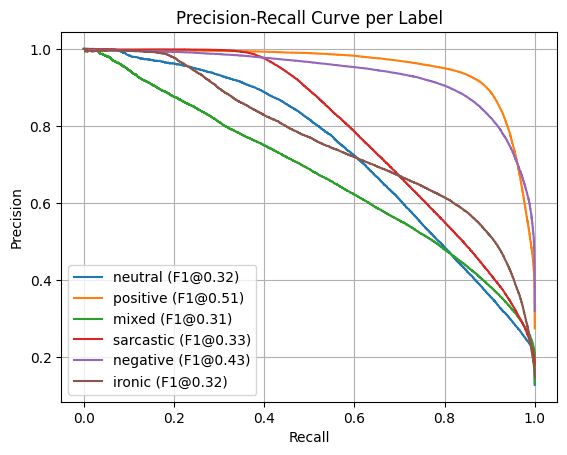

Best thresholds based on F1-score:
neutral: 0.319
positive: 0.509
mixed: 0.306
sarcastic: 0.332
negative: 0.428
ironic: 0.318


In [18]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

label_names = ['neutral', 'positive', 'mixed', 'sarcastic', 'negative', 'ironic']
best_thresholds = {}

for i, label in enumerate(label_names):
    precision, recall, thresholds = precision_recall_curve(y_true[:, i], y_probs[:, i])
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
    best_idx = np.argmax(f1_scores)
    best_thresh = thresholds[best_idx]

    best_thresholds[label] = round(best_thresh, 3)

    plt.plot(recall, precision, label=f"{label} (F1@{best_thresh:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve per Label")
plt.legend()
plt.grid(True)
plt.show()

# Round thresholds to 3 decimal places
rounded_thresholds = {label: round(float(thresh), 3) for label, thresh in best_thresholds.items()}

# Print thresholds
print("Best thresholds based on F1-score:")
for label, thresh in rounded_thresholds.items():
    print(f"{label}: {thresh}")

### Text Reviews with Best Custom Thresholds based on F1-Score

In [ ]:
import torch

# Custom thresholds from F1 optimisation
custom_thresholds = {
    'neutral': 0.319,
    'positive': 0.509,
    'mixed': 0.306,
    'sarcastic': 0.332,
    'negative': 0.428,
    'ironic': 0.318
}

# Prediction using custom thresholds
def predict_custom_thresholds(text):
    encoding = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=128)
    encoding = {k: v.to(model.device) for k, v in encoding.items()}

    with torch.no_grad():
        logits = model(**encoding).logits
        probs = torch.sigmoid(logits)[0].cpu().numpy()

    preds = [label_names[i] for i, p in enumerate(probs) if p >= custom_thresholds[label_names[i]]]
    return preds, probs

# Run predictions on test reviews using custom thresholds
for i, (review, expected) in enumerate(test_reviews, 1):
    predicted_labels, probabilities = predict_custom_thresholds(review)
    print(f"\n🔹 Review #{i}")
    print(f"📝 Text: {review}")
    print(f"🎯 Expected: {expected}")
    print(f"✅ Predicted: {predicted_labels}")
    print("📊 Probabilities:", {label_names[j]: round(prob, 3) for j, prob in enumerate(probabilities)})
    print("-" * 60)


🔹 Review #1
📝 Text: Absolutely amazing product! It exceeded my expectations!
🎯 Expected: ['positive']
✅ Predicted: ['positive']
📊 Probabilities: {'neutral': 0.001, 'positive': 0.993, 'mixed': 0.003, 'sarcastic': 0.011, 'negative': 0.005, 'ironic': 0.003}
------------------------------------------------------------

🔹 Review #2
📝 Text: Fantastic service, will definitely use again!
🎯 Expected: ['positive']
✅ Predicted: ['positive']
📊 Probabilities: {'neutral': 0.001, 'positive': 0.981, 'mixed': 0.004, 'sarcastic': 0.267, 'negative': 0.011, 'ironic': 0.006}
------------------------------------------------------------

🔹 Review #3
📝 Text: This is hands down the best thing I’ve bought!
🎯 Expected: ['positive']
✅ Predicted: ['positive']
📊 Probabilities: {'neutral': 0.008, 'positive': 0.923, 'mixed': 0.008, 'sarcastic': 0.111, 'negative': 0.003, 'ironic': 0.036}
------------------------------------------------------------

🔹 Review #4
📝 Text: I love it! Works perfectly every time.
🎯 Expected

### Text Reviews with Custom Thresholds V2 (Error Analysis & Adjustments)

In [ ]:
import torch

# ------------------------------------------------------------
# Custom Thresholds (Tuned based on test set analysis)
# ------------------------------------------------------------
# Notes:
# - 'positive' and 'negative' thresholds are kept unchanged due to high precision and recall.
# - 'neutral' is slightly increased to reduce overlap with 'mixed'.
# - 'mixed' is lowered to catch more subtle good+bad expressions.
# - 'sarcastic' lowered slightly to improve detection of dry sarcasm.
# - 'ironic' lowered due to consistent under-detection of ironic cues.
# ------------------------------------------------------------

custom_thresholds = {
    'neutral': 0.34,     # Slightly raised from 0.319 – avoids confusion with 'mixed'
    'positive': 0.509,   # Kept same – excellent accuracy
    'mixed': 0.28,       # Lowered from 0.306 – improve sensitivity to nuanced reviews
    'sarcastic': 0.31,   # Slightly lowered from 0.332 – better detection of softer sarcasm
    'negative': 0.428,   # Kept same – reliable detection
    'ironic': 0.28       # Lowered from 0.318 – improves detection of ironic tone
}

# Prediction using custom thresholds
def predict_custom_thresholds(text):
    encoding = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=128)
    encoding = {k: v.to(model.device) for k, v in encoding.items()}

    with torch.no_grad():
        logits = model(**encoding).logits
        probs = torch.sigmoid(logits)[0].cpu().numpy()

    preds = [label_names[i] for i, p in enumerate(probs) if p >= custom_thresholds[label_names[i]]]
    return preds, probs

# Run predictions on test reviews using custom thresholds
for i, (review, expected) in enumerate(test_reviews, 1):
    predicted_labels, probabilities = predict_custom_thresholds(review)
    print(f"\n🔹 Review #{i}")
    print(f"📝 Text: {review}")
    print(f"🎯 Expected: {expected}")
    print(f"✅ Predicted: {predicted_labels}")
    print("📊 Probabilities:", {label_names[j]: round(prob, 3) for j, prob in enumerate(probabilities)})
    print("-" * 60)


🔹 Review #1
📝 Text: Absolutely amazing product! It exceeded my expectations!
🎯 Expected: ['positive']
✅ Predicted: ['positive']
📊 Probabilities: {'neutral': 0.001, 'positive': 0.993, 'mixed': 0.003, 'sarcastic': 0.011, 'negative': 0.005, 'ironic': 0.003}
------------------------------------------------------------

🔹 Review #2
📝 Text: Fantastic service, will definitely use again!
🎯 Expected: ['positive']
✅ Predicted: ['positive']
📊 Probabilities: {'neutral': 0.001, 'positive': 0.981, 'mixed': 0.004, 'sarcastic': 0.267, 'negative': 0.011, 'ironic': 0.006}
------------------------------------------------------------

🔹 Review #3
📝 Text: This is hands down the best thing I’ve bought!
🎯 Expected: ['positive']
✅ Predicted: ['positive']
📊 Probabilities: {'neutral': 0.008, 'positive': 0.923, 'mixed': 0.008, 'sarcastic': 0.111, 'negative': 0.003, 'ironic': 0.036}
------------------------------------------------------------

🔹 Review #4
📝 Text: I love it! Works perfectly every time.
🎯 Expected

### Text Reviews with Custom Thresholds V3

In [ ]:
import torch

# ------------------------------------------------------------
# Custom Thresholds (Updated: Post-Results 2 Review)
# ------------------------------------------------------------
# Notes:
# - 'ironic' reduced to 0.16 to improve sensitivity — currently 0% accuracy.
# - 'mixed' lowered further to 0.25 to better capture nuanced reviews (26.3% accuracy).
# - 'neutral' slightly increased to 0.36 to reduce overlap with 'mixed' and sarcasm.
# - 'sarcastic' lowered slightly to 0.29 to help detect dry or subtle sarcasm (currently 31.2%).
# - 'positive' remains at 0.509 – decent performance, no major issues.
# - 'negative' remains at 0.428 – currently the most accurate (60%).
# ------------------------------------------------------------

custom_thresholds = {
    'neutral': 0.36,     # Raised to reduce false positives from 'mixed' or 'ironic'
    'positive': 0.509,   # Stable – 50% accuracy
    'mixed': 0.25,       # Lowered further to capture subtle contradictions
    'sarcastic': 0.29,   # Tweaked for better sensitivity on mild sarcasm
    'negative': 0.428,   # Solid – best performing label
    'ironic': 0.16       # Significantly lowered – previously 0% accuracy
}

# Prediction using updated custom thresholds
def predict_custom_thresholds(text):
    encoding = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=128)
    encoding = {k: v.to(model.device) for k, v in encoding.items()}

    with torch.no_grad():
        logits = model(**encoding).logits
        probs = torch.sigmoid(logits)[0].cpu().numpy()

    preds = [label_names[i] for i, p in enumerate(probs) if p >= custom_thresholds[label_names[i]]]
    return preds, probs

# Run predictions on test reviews using updated thresholds
for i, (review, expected) in enumerate(test_reviews, 1):
    predicted_labels, probabilities = predict_custom_thresholds(review)
    print(f"\n🔹 Review #{i}")
    print(f"📝 Text: {review}")
    print(f"🎯 Expected: {expected}")
    print(f"✅ Predicted: {predicted_labels}")
    print("📊 Probabilities:", {label_names[j]: round(prob, 3) for j, prob in enumerate(probabilities)})
    print("-" * 60)


🔹 Review #1
📝 Text: Absolutely amazing product! It exceeded my expectations!
🎯 Expected: ['positive']
✅ Predicted: ['positive']
📊 Probabilities: {'neutral': 0.001, 'positive': 0.993, 'mixed': 0.003, 'sarcastic': 0.011, 'negative': 0.005, 'ironic': 0.003}
------------------------------------------------------------

🔹 Review #2
📝 Text: Fantastic service, will definitely use again!
🎯 Expected: ['positive']
✅ Predicted: ['positive']
📊 Probabilities: {'neutral': 0.001, 'positive': 0.981, 'mixed': 0.004, 'sarcastic': 0.267, 'negative': 0.011, 'ironic': 0.006}
------------------------------------------------------------

🔹 Review #3
📝 Text: This is hands down the best thing I’ve bought!
🎯 Expected: ['positive']
✅ Predicted: ['positive']
📊 Probabilities: {'neutral': 0.008, 'positive': 0.923, 'mixed': 0.008, 'sarcastic': 0.111, 'negative': 0.003, 'ironic': 0.036}
------------------------------------------------------------

🔹 Review #4
📝 Text: I love it! Works perfectly every time.
🎯 Expected

### Text Reviews with Custom Thresholds V4

In [ ]:
import torch

custom_thresholds = {
    'neutral': 0.39,     # Slightly increased to suppress overlap with mixed/sarcastic
    'positive': 0.509,   # Keep the same — strong performance
    'mixed': 0.22,       # Slightly lower to boost detection when close to neutral
    'sarcastic': 0.29,   # Slight bump to avoid false positives (e.g., Review #2)
    'negative': 0.428,   # Keep the same — no issues
    'ironic': 0.16       # Slightly up from 0.14 to reduce borderline over-triggering
}

# Prediction using updated custom thresholds
def predict_custom_thresholds(text):
    encoding = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=128)
    encoding = {k: v.to(model.device) for k, v in encoding.items()}

    with torch.no_grad():
        logits = model(**encoding).logits
        probs = torch.sigmoid(logits)[0].cpu().numpy()

    preds = [label_names[i] for i, p in enumerate(probs) if p >= custom_thresholds[label_names[i]]]
    return preds, probs

# Run predictions on test reviews using updated thresholds
for i, (review, expected) in enumerate(test_reviews, 1):
    predicted_labels, probabilities = predict_custom_thresholds(review)
    print(f"\n🔹 Review #{i}")
    print(f"📝 Text: {review}")
    print(f"🎯 Expected: {expected}")
    print(f"✅ Predicted: {predicted_labels}")
    print("📊 Probabilities:", {label_names[j]: round(prob, 3) for j, prob in enumerate(probabilities)})
    print("-" * 60)


🔹 Review #1
📝 Text: Absolutely amazing product! It exceeded my expectations!
🎯 Expected: ['positive']
✅ Predicted: ['positive']
📊 Probabilities: {'neutral': 0.001, 'positive': 0.993, 'mixed': 0.003, 'sarcastic': 0.011, 'negative': 0.005, 'ironic': 0.003}
------------------------------------------------------------

🔹 Review #2
📝 Text: Fantastic service, will definitely use again!
🎯 Expected: ['positive']
✅ Predicted: ['positive']
📊 Probabilities: {'neutral': 0.001, 'positive': 0.981, 'mixed': 0.004, 'sarcastic': 0.267, 'negative': 0.011, 'ironic': 0.006}
------------------------------------------------------------

🔹 Review #3
📝 Text: This is hands down the best thing I’ve bought!
🎯 Expected: ['positive']
✅ Predicted: ['positive']
📊 Probabilities: {'neutral': 0.008, 'positive': 0.923, 'mixed': 0.008, 'sarcastic': 0.111, 'negative': 0.003, 'ironic': 0.036}
------------------------------------------------------------

🔹 Review #4
📝 Text: I love it! Works perfectly every time.
🎯 Expected

# Visualization

Precision, Recall, F1-Score Bar Chart

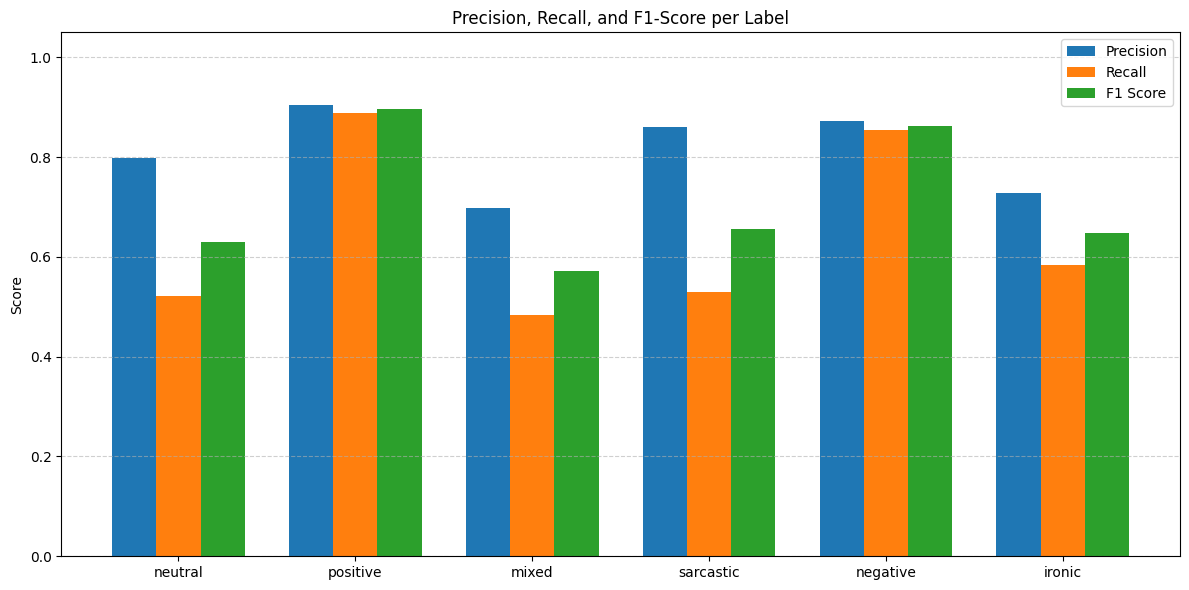

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_fscore_support

# Calculate precision, recall, f1 for each class
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, zero_division=0)

x = np.arange(len(all_possible_labels))  # label positions
width = 0.25  # bar width

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(x - width, precision, width, label='Precision')
plt.bar(x, recall, width, label='Recall')
plt.bar(x + width, f1, width, label='F1 Score')

plt.ylabel('Score')
plt.title('Precision, Recall, and F1-Score per Label')
plt.xticks(x, all_possible_labels)
plt.ylim(0, 1.05)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Confusion Matrix Heatmaps (Per-Label)

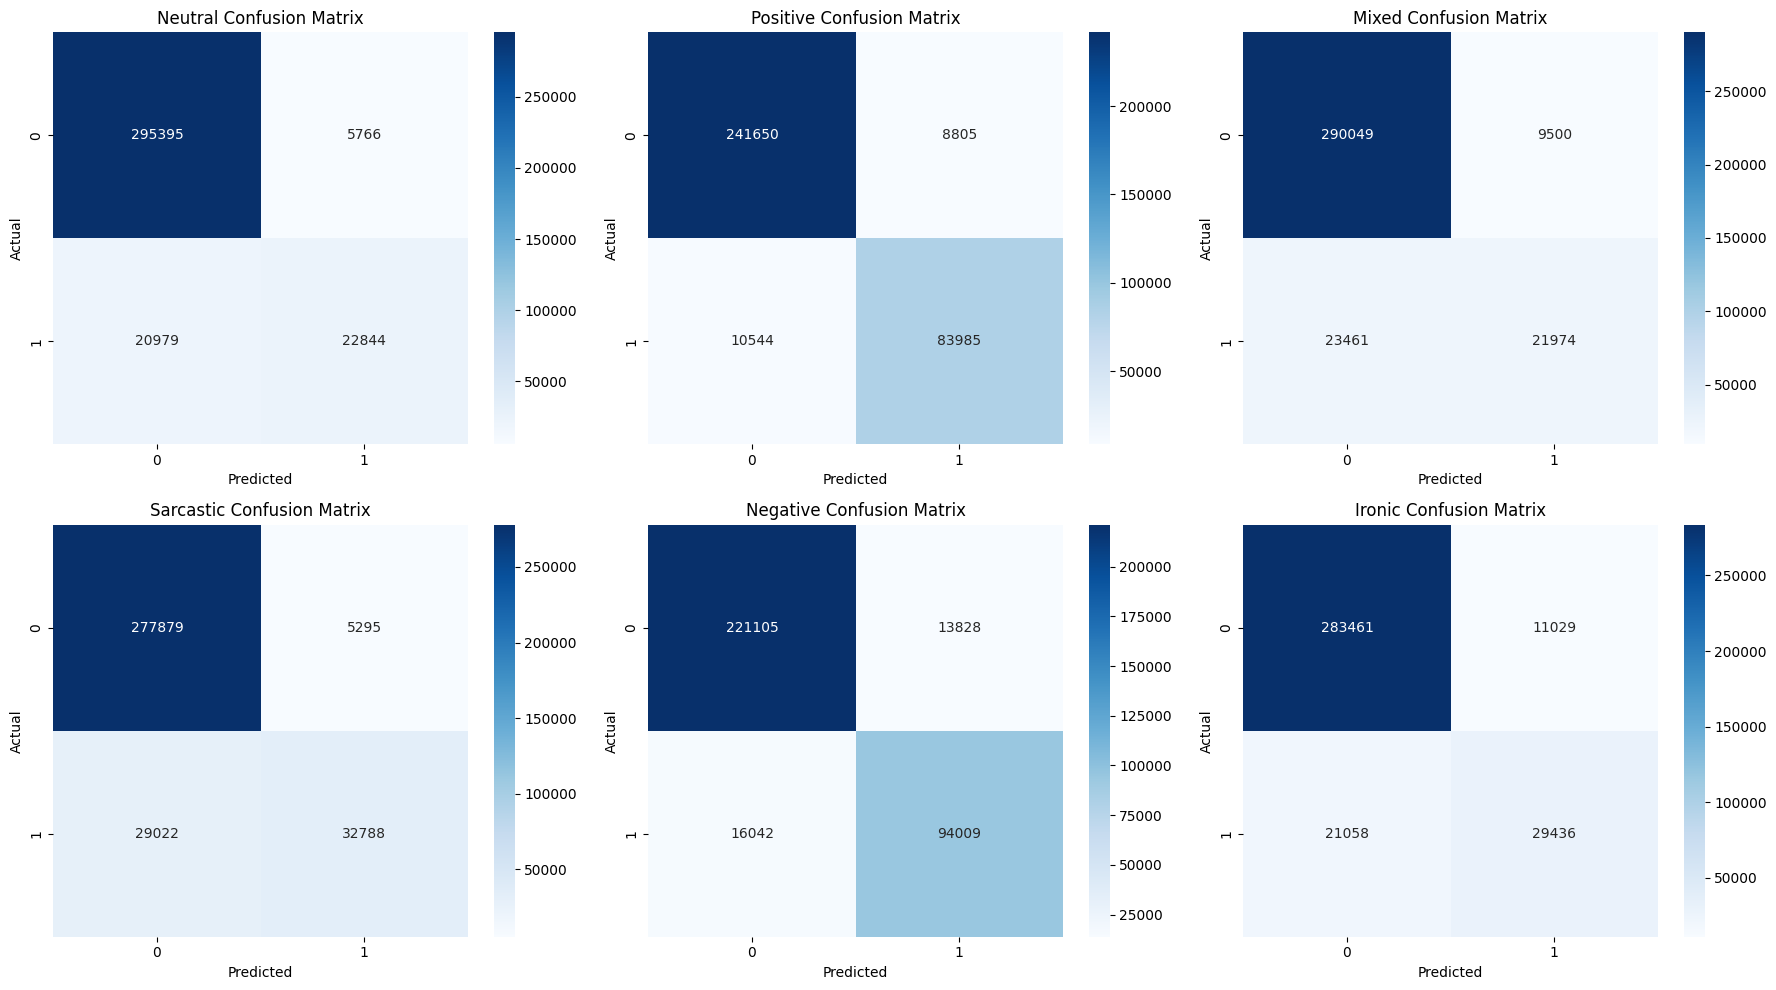

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Set up subplots (2 rows, 3 columns)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()  # Flatten to easily iterate

# Plot confusion matrix for each label
for i, label in enumerate(all_possible_labels):
    cm = confusion_matrix(y_true[:, i], y_pred[:, i])
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', ax=axes[i], cbar=True)
    axes[i].set_title(f"{label.capitalize()} Confusion Matrix")
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Actual")

plt.tight_layout()
plt.show()

Label Distribution Plot

C:\Users\Luximano\AppData\Local\Temp\ipykernel_16024\2661118032.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette="pastel")


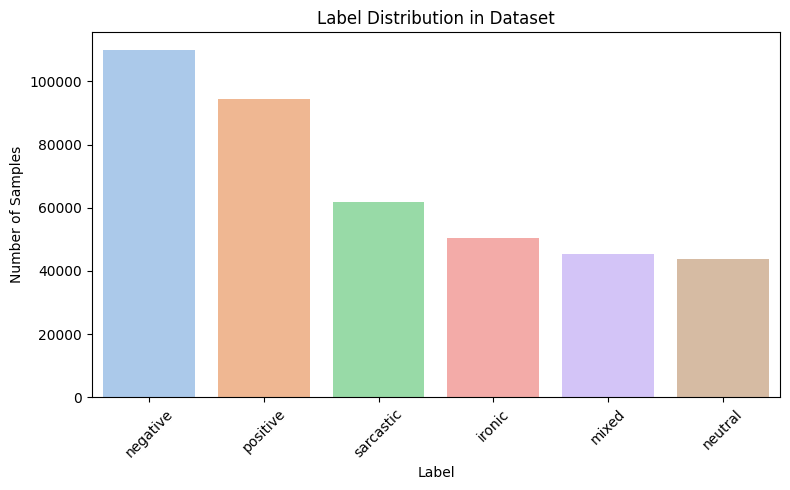

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count how many times each label appears
label_counts = df[all_possible_labels].sum().sort_values(ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="pastel")
plt.title("Label Distribution in Dataset")
plt.ylabel("Number of Samples")
plt.xlabel("Label")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()